### Installations and imports

In [70]:
# The selfmade labels  in "/picture_masks/masks_chaco" were done with label-studio

# Install the Label Studio package
#!pip install -U label-studio

# Launch it!
#!label-studio

In [69]:
#Create patches out of an image
#!pip install patchify

In [123]:
# Uninstall all conflicting packages
!pip uninstall -y tensorflow keras tf-keras segmentation-models efficientnet

# Install specific versions
!pip install -q tensorflow==2.8.0

# Upgrade google-auth-oauthlib to the required version for pandas-gbq
!pip install -q --upgrade google-auth-oauthlib==0.4.6

# Install segmentation model
!pip install -U -q segmentation-models 

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Successfully uninstalled segmentation-models-1.0.1
Found existing installation: efficientnet 1.0.0
Uninstalling efficientnet-1.0.0:
  Successfully uninstalled efficientnet-1.0.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [124]:
#Files management
import os
from pathlib import Path
import glob

#Standard packages
import numpy as np
import pandas as pd
import random
import re
from matplotlib import pyplot as plt

#Images management
import cv2
from PIL import Image
from patchify import patchify

#Preprocess
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
# you need to provide the datatype and the number of labels
from tensorflow.keras.utils import to_categorical 

In [125]:
#Keras needed functions for NN architecture

# gives us the scelleton for the calculation not doing the calculations
from keras.models import Model
# Stuff necessary to create the Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get other methods
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda 

# Calculations in the backend (tensor level calculation in tensorflow)
from keras import backend as K 

In [126]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
import segmentation_models as sm

print(f'TensorFlow version: {tf.__version__}')
print(f'Segmentation Models version: {sm.__version__}')

TensorFlow version: 2.15.1
Segmentation Models version: 1.0.1


In [127]:
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report #model assesment
import seaborn as sns #heatmap

### Images preprocessing

#### Extract images and assign to types of datasets (train, val, test)

In [7]:
current_working_directory = os.getcwd()
print(current_working_directory)

/home/scc/lennart.giessing


In [8]:
dataset_root_folder = '/home/scc/lennart.giessing' #current_working_directory

In [9]:
img_folder = "/satellite_chaco"
masks_folder = "/masks_chaco"

directory = dataset_root_folder + "/pictures_masks"
directory_img = directory + img_folder

# List all files in the directory
file_list = [f for f in os.listdir(directory_img) if os.path.isfile(os.path.join(directory_img, f))]

In [10]:
file_list

['Clipped_Scaled_Composite_2014_4.jpg',
 'Clipped_Scaled_Composite_2014_3.jpg',
 'Clipped_Scaled_Composite_2019_3.jpg',
 'Clipped_Scaled_Composite_2019_4.jpg',
 'Clipped_Scaled_Composite_2014_2.jpg',
 'Clipped_Scaled_Composite_2019_2.jpg',
 'Clipped_Scaled_Composite_2019_1.jpg',
 'Clipped_Scaled_Composite_2014_1.jpg']

In [11]:
#Images 1 and 2 correspond to training
training_set = [file_list[i] for i in [7, 6, 4, 5]]

#Image 3 correspond to validation
validation_set = [file_list[i] for i in [1, 2]]

#Image 4 correspond to testing
test_set = [file_list[i] for i in [0, 3]]

#### Patching

##### One-image trial

In [12]:
# Standard patch size chosen 256 pixels
image_patch_size = 256

In [13]:
image = cv2.imread(f'{directory_img}/{training_set[0]}',1)

In [14]:
image.shape # images have different shapes -> problem!

(1040, 1708, 3)

Height (1040 pixels) <br>
Number of patches along the height: floor(1040/256)= 4 patches<br>
Total pixels covered: 4×256=1024 pixels<br>
Pixels missed along the height: 1040−1024=16 pixels<br>

Width (1708 pixels)<br>
Number of patches along the Width: floor(1708/256)= 6 patches<br>
Total pixels covered: 6×256=1536 pixels<br>
Pixels missed along the Width: 1708−1536=172 pixels<br>

Total missed pixels per image = 16 + 172 = 188 pixels

In [15]:
#Patch (3 due to RGB)
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [16]:
len(image_patches)

4

In [17]:
print(image_patches.shape)
#4: number of batches
#6: number of images per batch
#4*6 = 24, number of training cases for the image

#1: placeholder or represents a single channel (?)
#256: dimension
#3: RGB

(4, 6, 1, 256, 256, 3)


Scaling

In [18]:
minmaxscaler = MinMaxScaler()

In [19]:
image_x = image_patches[0,0,:,:]
#image_patches[0, 0]: This accesses the first batch and the first patch within that batch.
#image_patches[0, 0, :, :]: This removes the singleton dimension (1) by selecting all elements 
#across the last three axes, resulting in an array with the shape (256, 256, 3).

#MinMaxScaler
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)
#Flatten array for scaling
#The -1 means that the number of rows is inferred automatically. The resulting shape would be (65536, 3), 
#where 65536 (which is 256x256) is the total number of pixels, and 3 is the number of color channels.

#Reshape to the original form
#After scaling, the flattened 2D array (65536, 3) is reshaped back to its original 3D shape (256, 256, 3) so 
#that image_y represents the scaled image in the same format as image_x.

In [20]:
#scaled image
image_y[0].shape

(256, 256, 3)

##### Systematize patching without losing image extension

In [21]:
def image_patches(batch_type_obj, minmax_scaler= True):
    #batch_type_obj: a list of names with the image files
    
    image_dataset = [] # images
    mask_dataset = [] # masks
    
    #2 folders with different names contain the images and masks
    for image_type in ['satellite_chaco' , 'masks_chaco']:
        #images and corresponding masks are named equally
        for image_id in batch_type_obj:
            #Path
            image_dir = directory + f"/{image_type}/{image_id}"
            #Read image
            image = cv2.imread(image_dir,1)
            if image is not None:
                print(f"/{image_type}/{image_id}")
                
                ### Change image dimensions to fit in patches of 256 not lose satellite image extension
                # Calculate the closest dimension of the image that is divisible by the patch size.
                size_x = (image.shape[1]//image_patch_size)*image_patch_size 
                size_y = (image.shape[0]//image_patch_size)*image_patch_size 
                #print("{} --- {} - {}".format(image.shape, size_x, size_y))
                
                ## Crop the image to slice it into a size based on the multiple of 256
                # transform again from array to PIL(Python Imaging Library)
                image = Image.fromarray(image)
                image = image.crop((0,0, size_x, size_y)) 
                #print("({},  {})".format(image.size[0],image.size[1]))
                image = np.array(image)
                
                ### Patch
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                #print(len(patched_images))
                
                for i in range(patched_images.shape[0]):
                      for j in range(patched_images.shape[1]):
                            if image_type == 'satellite_chaco':
                                individual_patched_image = patched_images[i,j,:,:]
                                #print(individual_patched_image.shape)
                                # Reshapes to flat, scales the pixel values to sth. between 0 and 1, reshapes to 256x256
                                individual_patched_image = individual_patched_image[0] # append to empty dataframe
                                if minmax_scaler:
                                    individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                                #print(individual_patched_image.shape)
                                image_dataset.append(individual_patched_image)
                                
                            elif image_type == 'masks_chaco': # patch the masks as well, but do not change their scale
                                individual_patched_mask = patched_images[i,j,:,:]
                                individual_patched_mask = individual_patched_mask[0]
                                mask_dataset.append(individual_patched_mask)
                                
    return np.array(image_dataset), np.array(mask_dataset)

##### Patch training dataset

In [22]:
tr_image_dataset, tr_mask_dataset = image_patches(training_set, minmax_scaler = True)

/satellite_chaco/Clipped_Scaled_Composite_2014_1.jpg
/satellite_chaco/Clipped_Scaled_Composite_2019_1.jpg
/satellite_chaco/Clipped_Scaled_Composite_2014_2.jpg
/satellite_chaco/Clipped_Scaled_Composite_2019_2.jpg
/masks_chaco/Clipped_Scaled_Composite_2014_1.jpg
/masks_chaco/Clipped_Scaled_Composite_2019_1.jpg
/masks_chaco/Clipped_Scaled_Composite_2014_2.jpg
/masks_chaco/Clipped_Scaled_Composite_2019_2.jpg


In [23]:
print(len(tr_image_dataset))
print(len(tr_mask_dataset))

96
96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


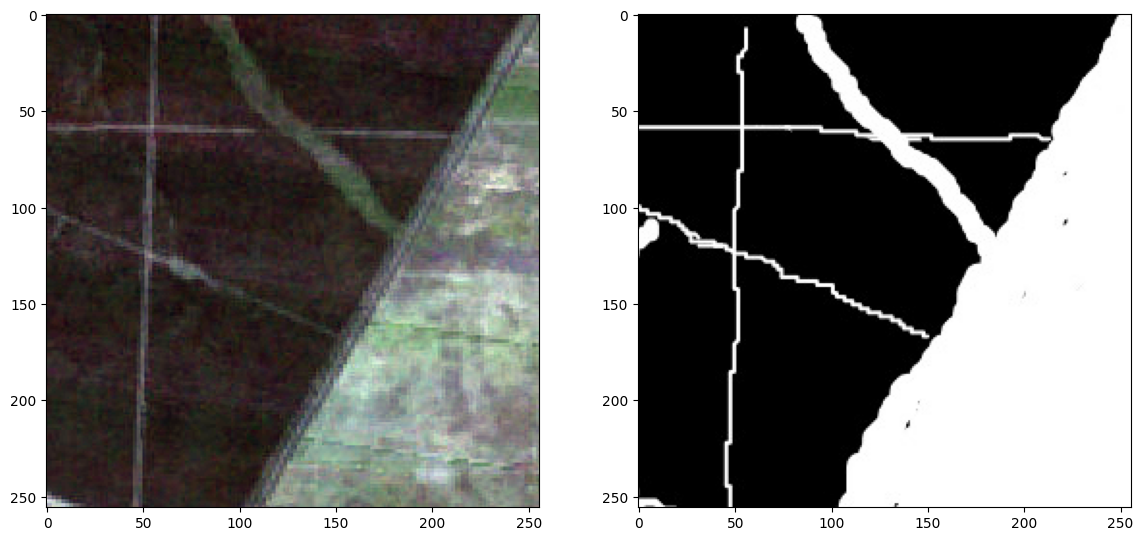

In [24]:
#Visualize patch
random.seed(15)

# select random image plus the belonging mask
random_image_id = random.randint(0, len(tr_image_dataset)) 

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(tr_image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(tr_mask_dataset[random_image_id])
plt.savefig('report_figures/normalization_mask.png')

##### Data Augmentation

In [27]:
# Rotate the images and masks by 90°, 180°, and 270° to the right (clockwise)
tr_image_dataset_90 = np.rot90(tr_image_dataset, k=-1, axes=(1, 2))
tr_mask_dataset_90 = np.rot90(tr_mask_dataset, k=-1, axes=(1, 2))

tr_image_dataset_180 = np.rot90(tr_image_dataset, k=-2, axes=(1, 2))
tr_mask_dataset_180 = np.rot90(tr_mask_dataset, k=-2, axes=(1, 2))

tr_image_dataset_270 = np.rot90(tr_image_dataset, k=-3, axes=(1, 2))
tr_mask_dataset_270 = np.rot90(tr_mask_dataset, k=-3, axes=(1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


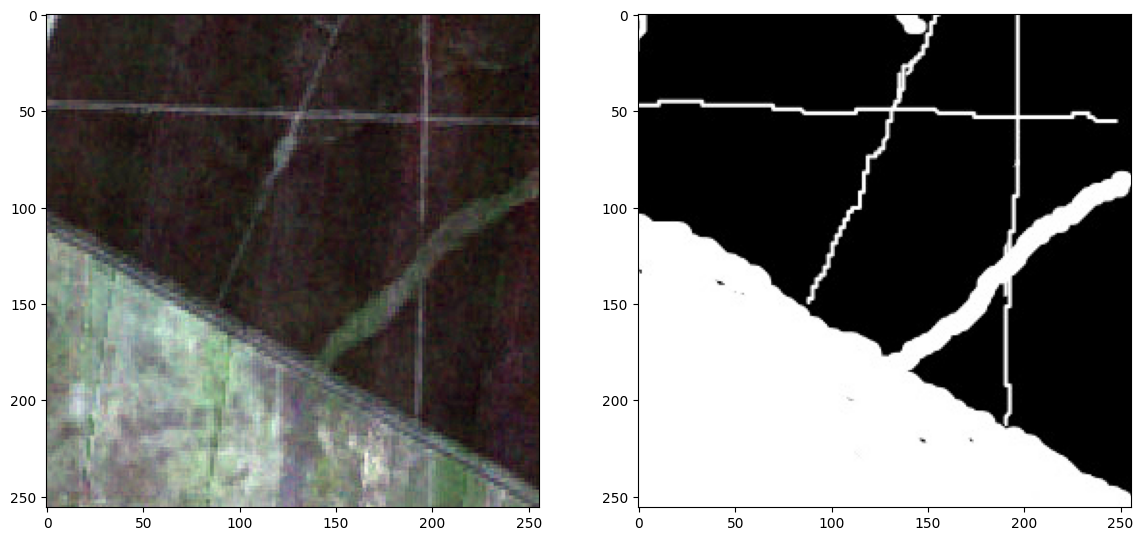

In [28]:
#Visualize patch
random.seed(15)

# select random image plus the belonging mask
random_image_id = random.randint(0, len(tr_image_dataset_270)) 

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(tr_image_dataset_90[random_image_id])
plt.subplot(122)
plt.imshow(tr_mask_dataset_90[random_image_id])

In [29]:
# Concatenate the original and rotated datasets
aug_image_dataset = np.concatenate((tr_image_dataset, tr_image_dataset_90, tr_image_dataset_180), axis=0)
aug_mask_dataset = np.concatenate((tr_mask_dataset, tr_mask_dataset_90, tr_mask_dataset_180), axis=0)

# Verify the shape to ensure we have 384 images and masks
print("Final image dataset shape:", aug_image_dataset.shape)
print("Final mask dataset shape:", aug_mask_dataset.shape)

# Save the final dataset if needed
np.save('aug_image_dataset.npy', aug_image_dataset)
np.save('aug_mask_dataset.npy', aug_mask_dataset)

Final image dataset shape: (288, 256, 256, 3)
Final mask dataset shape: (288, 256, 256, 3)


#### Labeling pixels (from RGB to one-hot vector)

##### Labeling functions

In [30]:
# Transfer known HEX color to RGB 
class_forest = '#000000' # Hex string representation, black
class_forest = class_forest.lstrip('#') # get rid of the #
class_forest = np.array(tuple(int(class_forest[i:i+2], 16) for i in (0,2,4))) # Split the value into its three segments
                                                                              # convert each two-character hex string into an integer interpreting it as a base 16 Number (60, 16, 152) these are the RBG values necessary for the colours
class_no_forest = '#FFFFFF' # Hex string representation, white
class_no_forest = class_no_forest.lstrip('#')
class_no_forest = np.array(tuple(int(class_no_forest[i:i+2], 16) for i in (0,2,4)))

print(class_forest)
print(class_no_forest)

[0 0 0]
[255 255 255]


In [31]:
# Function to convert an RGB image into a labeled image where ecah pixel represents a specific class and not a colour as before
def rgb_to_label(label, priotize_no_forest = True):
    
    #Zeros/ones array
    if priotize_no_forest:
        label_segment = np.zeros(label.shape, dtype=np.uint8)
        label_segment[np.all(label == class_forest, axis=-1)] = 1 
        
    else:
        label_segment = np.ones(label.shape, dtype=np.uint8)
        label_segment[np.all(label == class_no_forest, axis=-1)] = 0
    
    # Reduces the label from 3d into 2d because all channels have the same label
    label_segment = label_segment[:,:,0] 
    #print(label_segment)
    
    return label_segment

In [32]:
def label_dataset(mask_dataset):
    
    labels = []
    for i in range(len(mask_dataset)):
        label = rgb_to_label(mask_dataset[i])
        labels.append(label)
        
    #Add channel dimension for CNN
    labels = np.expand_dims(np.array(labels), axis=3)
    
    return labels

##### Label and one-hot encode training dataset

In [33]:
aug_labels = label_dataset(aug_mask_dataset)

In [34]:
aug_labels.shape

(288, 256, 256, 1)

In [35]:
#Change integers to one-hot encoding vectors to avoid ordering problems
#(usually not useful for binary cases but kept for possible changes in labelling)
aug_labels_cat = to_categorical(aug_labels, num_classes=2)

In [36]:
aug_labels[0][0][0]

array([1], dtype=uint8)

In [37]:
aug_labels_cat[0][0][0]

array([0., 1.], dtype=float32)

Forest (1) is in the second position of the one-hot vector

##### Non-augmented transformations

In [38]:
tr_labels = label_dataset(tr_mask_dataset)
tr_labels_cat = to_categorical(tr_labels, num_classes=2)

In [39]:
#tr_image_dataset
#tr_labels_cat

##### Visualize training images and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


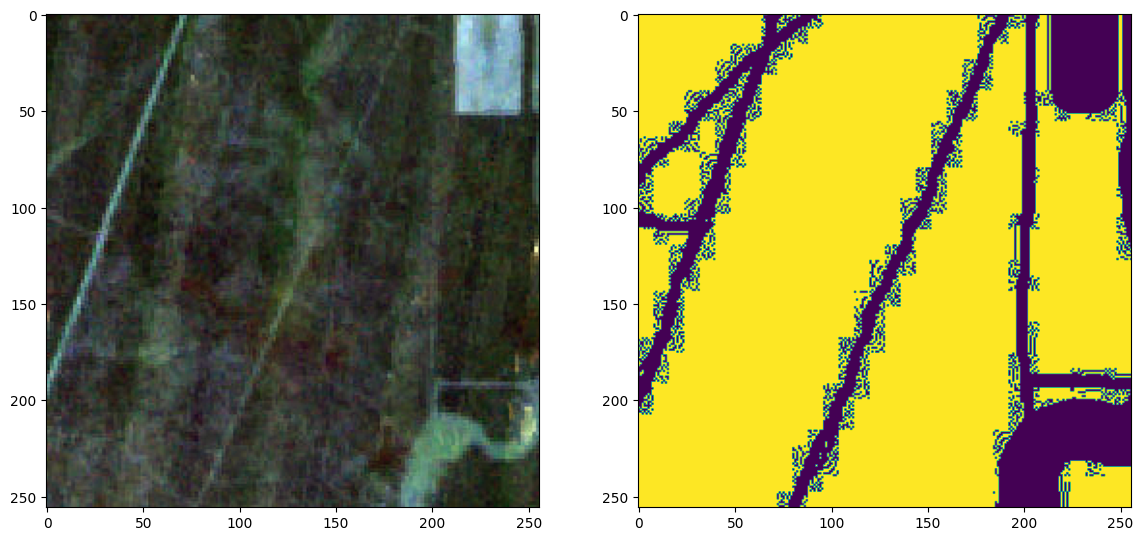

In [40]:
random.seed(15)
random_image_id = random.randint(0, len(aug_image_dataset)) # plot the images and the changed masks

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(aug_image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(aug_labels[random_image_id][:,:,0])
plt.savefig('report_figures/normalization_labelling.png')

#### Validation dataset patching, labelling and one-hot encoding

In [41]:
#Patches for images
val_image_dataset, val_mask_dataset = image_patches(validation_set)

#Label out of mask and categorial one-hot encodings
val_labels = label_dataset(val_mask_dataset)
val_labels_cat = to_categorical(val_labels, num_classes=2)

/satellite_chaco/Clipped_Scaled_Composite_2014_3.jpg
/satellite_chaco/Clipped_Scaled_Composite_2019_3.jpg
/masks_chaco/Clipped_Scaled_Composite_2014_3.jpg
/masks_chaco/Clipped_Scaled_Composite_2019_3.jpg


#### Training and validation datasets with standard names

In [42]:
X_train, y_train = aug_image_dataset, aug_labels_cat
X_val, y_val = val_image_dataset, val_labels_cat

In [43]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(288, 256, 256, 3)
(288, 256, 256, 2)
(48, 256, 256, 3)
(48, 256, 256, 2)


In [44]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]

total_classes = y_train.shape[3]

In [45]:
print("height:", image_height)
print("width:", image_width)
print("image_channels:", image_channels)
print("label_classes:", total_classes)

height: 256
width: 256
image_channels: 3
label_classes: 2


### Model specifications

#### Model architecture

In [76]:
#  Implementing U-Net Model
def multi_unet_model1(n_classes=2, image_height=256, 
                     image_width=256, image_channels=3):
    
    #Define dimensionality of the inputs
    inputs = Input((image_height, image_width, image_channels))
    source_input = inputs
    
    ### Convolutions and pooling (encoder)
    
    ##First convolutional block (c1) with 2 convolutions, a dropout and a max pooling
    #First convolution
    c1 = Conv2D(16,   # 16 filters
                (3,3), # 3*3 convolutions
                activation="relu", # rectified linear unit (Relu), activation function after filter
                kernel_initializer="he_normal", # he_normal as weight initialization method
                padding="same",
                kernel_regularizer=l2(L2_reg))(source_input) # "same" keeps image dimension after convolution (here 3x3 filter application)
    # Dropout for NN robustness
    c1 = Dropout(0.2)(c1) #20% of nodes are dropped during traning
    #Second convolution
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c1) 
    # Max pooling operation for downsampling
    p1 = MaxPooling2D((2,2))(c1) #stride of 2 
    ## First convolutional block finishes
    
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(p1) #input from previous block
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(p2) 
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    # this is the bottlneck of the U-Net where the image is at its smallest representation
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(p4) 
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c5)
    
    ### Up-pooling and Convolutions (decoder with skip connections with encoder)
    
    # Upsampling starts by a 2*2 convolution, that halves the number of feature channels
    ##First upsampling block with one upsampling convolution, a skip connection, 2 convolutions and a dropout layer
    #Transposed convolution (deconvolution or upsampling convolution)
    u6 = Conv2DTranspose(128, #filters
                         (2,2), #filter/kernel size
                         strides=(2,2), #in upsampling stride of 2x2 doubles the spacial dimension
                         padding="same",
                        kernel_regularizer=l2(L2_reg))(c5) #padding for keeping the upsampling as double
    #Concatenation of two outputs
    u6 = concatenate([u6, c4]) # links a downsampling and upsampling block ("long" skip connection)
    #First convolution with equal size output
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(u6)
    # Dropout for NN robustness
    c6 = Dropout(0.2)(c6) #20% of nodes are dropped during traning
    #Second convolution with equal size output
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c6)
    ## First upsampling block finishes

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same", kernel_regularizer=l2(L2_reg))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same", kernel_regularizer=l2(L2_reg))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same", kernel_regularizer=l2(L2_reg))(c8)
    # no further concatenation needed, so we use axis = 3. Not totally sure how this works
    u9 = concatenate([u9, c1], axis=3) #default axis is -1
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", kernel_regularizer=l2(L2_reg))(c9)
    
    # Softmax layer to create a proxy for classes "probabilities" from output
    outputs = Conv2D(n_classes,  #have nodes as number of classes (get a probability for each, as our example is binary could also have 1)
                     (1,1),      #define each pixel
                     activation="softmax")(c9) 

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [128]:
def dilated_model(n_classes=2, image_height=256, image_width=256, image_channels=3):
    
    # Define the input layer
    inputs = Input((image_height, image_width, image_channels))
    
    # 1. Conv2d(64) ReLU BN
    x1 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)
    
    # 2. Conv2d(64) ReLU BN
    x2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(x1)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)
    
    # 3. Conv2d(64) ReLU BN
    x3 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(x2)
    x3 = BatchNormalization()(x3)
    x3 = ReLU()(x3)
    
    # 4. Conv2d(64) ReLU BN
    x4 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(x3)
    x4 = BatchNormalization()(x4)
    x4 = ReLU()(x4)
    
    # 5. Conv2d(64) ReLU (Dilation = 2)
    x5 = Conv2D(64, (3, 3), padding="same", dilation_rate=2, kernel_initializer="he_normal")(x4)
    x5 = ReLU()(x5)
    
    # 6. Conv2d(64) ReLU (Dilation = 4)
    x6 = Conv2D(64, (3, 3), padding="same", dilation_rate=4, kernel_initializer="he_normal")(x5)
    x6 = ReLU()(x6)
    
    # 7. Conv2d(64) ReLU (Dilation = 6)
    x7 = Conv2D(64, (3, 3), padding="same", dilation_rate=6, kernel_initializer="he_normal")(x6)
    x7 = ReLU()(x7)
    
    # 8. Concatenate(output of 4 and 7) -> Conv2d(128) ReLU BN
    concat1 = concatenate([x4, x7], axis=3)
    x8 = Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal")(concat1)
    x8 = BatchNormalization()(x8)
    x8 = ReLU()(x8)
    
    # 9. Conv2d(64) ReLU BN
    x9 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(x8)
    x9 = BatchNormalization()(x9)
    x9 = ReLU()(x9)
    
    # 10. Concatenate(output of 2 and 9) -> Conv2d(128) ReLU BN
    concat2 = concatenate([x2, x9], axis=3)
    x10 = Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal")(concat2)
    x10 = BatchNormalization()(x10)
    x10 = ReLU()(x10)
    
    # 11. Conv2d(64) ReLU BN
    x11 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(x10)
    x11 = BatchNormalization()(x11)
    x11 = ReLU()(x11)
    
    # Output layer
    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(x11)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

#### Assesment measures (accuracy and jaccard index)

In [78]:
# The jaccard index (Intersection over Union (IoU))
def jaccard_index(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    
    # intersection/whole area
    #[substracting intersection not to contabilize twice]
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    
    return final_coef_value

In [79]:
metrics = ["accuracy", jaccard_index]

#### Model initialization and training hyperparameters

##### Initialization

In [129]:
#Hyperparameters
batch_size = 16
lr = 0.001
L2_reg = 0.0001

In [81]:
model1 = multi_unet_model1(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [130]:
model2 = dilated_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
# Uncomment this line to get model confiuration
# model1.get_config()

##### Training weights for classes, loss function and optimizer

Focal loss is used like in the amazonas paper, is useful for cases of uneven classes

In [131]:
# Equal weight for each class
weights = [0.50, 0.50] 

#Remember: forest (1) is in the second position of the one-hot vector, 
#if "few" pixels were cliff as forest the second weigth should be increased as hyperparameter

# Define the dice loss based on the weights of each label #segmentation models package
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [132]:
tf.keras.backend.clear_session() 
#Good practice to avoid interference and release memory with other models previously used

In [133]:
optimizer1 = Adam(learning_rate = lr) 
optimizer2 = SGD(learning_rate = lr)

In [86]:
model1.compile(optimizer=optimizer1, 
               loss=total_loss, 
               metrics=metrics)

In [87]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

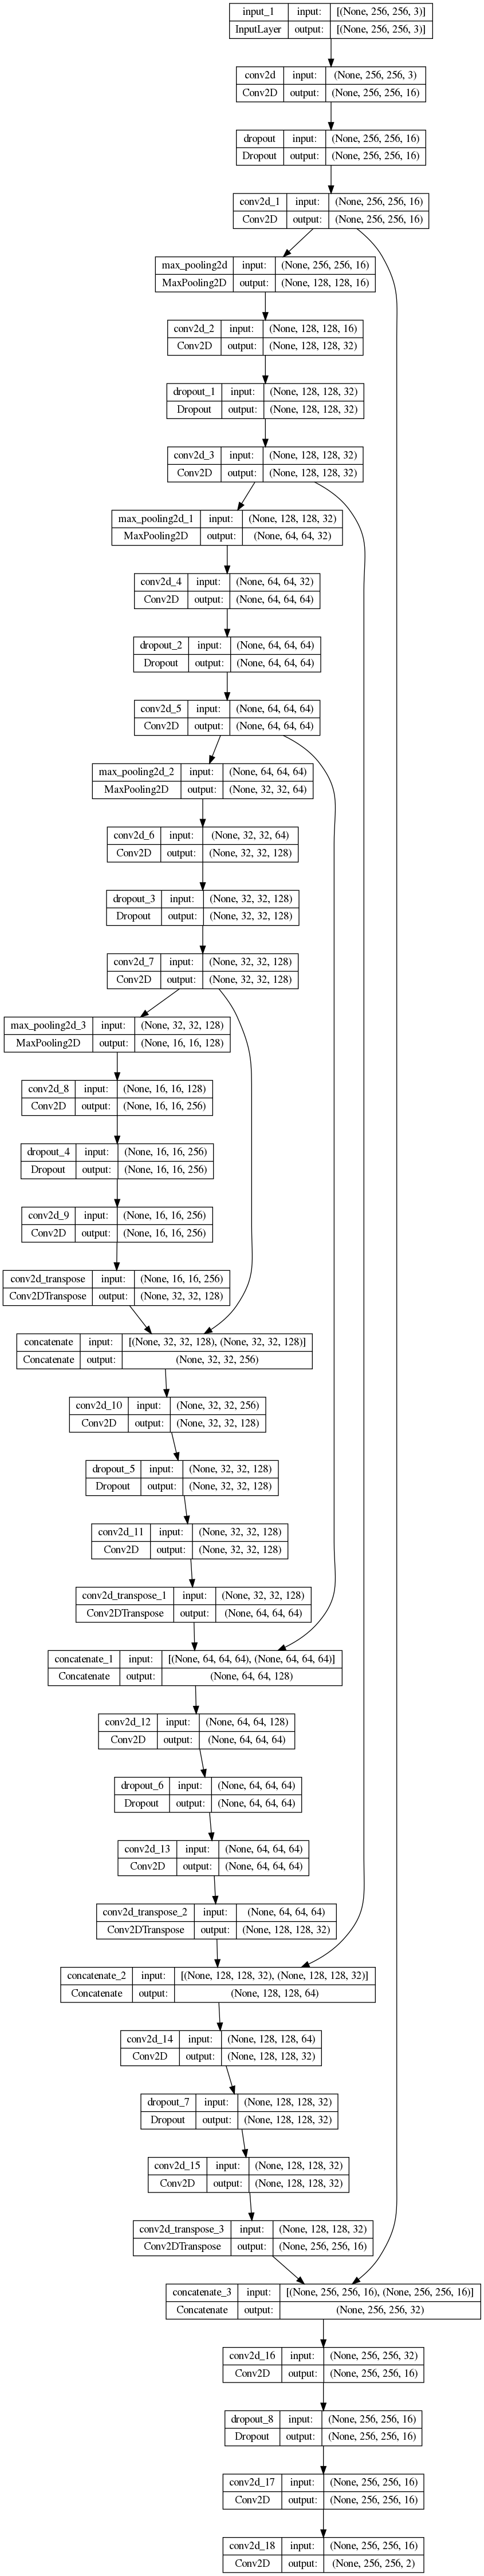

In [113]:
from keras.utils import plot_model
plot_model(model1, to_file='report_figures/model1.png', show_shapes=True,show_layer_names=True)

In [134]:
model2.compile(optimizer=optimizer2, 
               loss=total_loss, 
               metrics=metrics)

In [57]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 64)         0         ['batch_normalization[0]

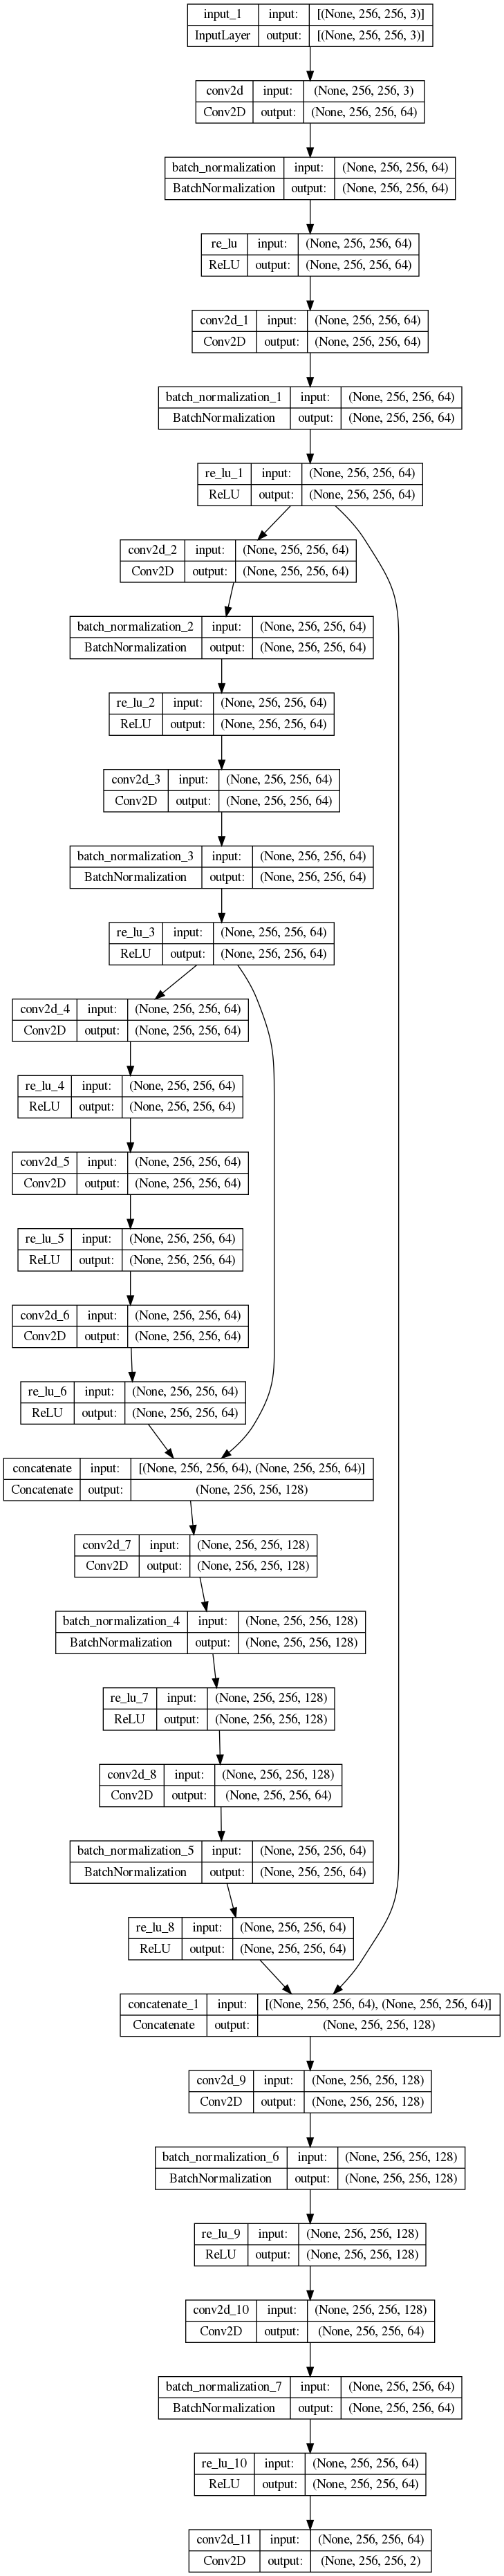

In [135]:
plot_model(model2, to_file='report_figures/model2.png', show_shapes=True,show_layer_names=True)

##### Early stopping definition

In [58]:
# Define the early stopping callback
early_stopping1 = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=25,          # Stop after 25 epochs with no improvement
    min_delta=0.0001,     # Minimum change to qualify as an improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1             # Print messages when stopping is triggered
)

# Define the model checkpoint callback
model_checkpoint1 = ModelCheckpoint(
    filepath='models/chaco_model_checkpoint1.h5',   # Filepath to save the model
    monitor='val_loss',         # Monitor validation loss
    save_best_only=True,        # Only save the model if the monitored value has improved
    verbose=1                   # Print messages when saving the model
)

early_stopping2 = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=25,          # Stop after 25 epochs with no improvement
    min_delta=0.0001,     # Minimum change to qualify as an improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1             # Print messages when stopping is triggered
)

# Define the model checkpoint callback
model_checkpoint2 = ModelCheckpoint(
    filepath='models/chaco_model_checkpoint2.h5',   # Filepath to save the model
    monitor='val_loss',         # Monitor validation loss
    save_best_only=True,        # Only save the model if the monitored value has improved
    verbose=1                   # Print messages when saving the model
)

### Model training & assessment metrics figures

#### Model training

In [134]:
model1_history = model1.fit(
    X_train, y_train,
    batch_size=batch_size,
    verbose=1,                # Display progress bar and metrics results for training and validation data
    epochs=100,               # Maximum number of epochs to train
    validation_data=(X_val, y_val),
    shuffle=True,             # Shuffle training data to prevent the model from learning data order
    callbacks=[early_stopping1, model_checkpoint1]  # Add the callbacks
)

model1.save('models/forest_chaco_saved_model1.h5')

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 1.0178 - accuracy: 0.5829 - jaccard_index: 0.3868
Epoch 1: val_loss improved from inf to 0.93691, saving model to models/chaco_model_checkpoint1.h5


/usr/local/jupyterhub/lib64/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 13s 448ms/step - loss: 1.0178 - accuracy: 0.5829 - jaccard_index: 0.3868 - val_loss: 0.9369 - val_accuracy: 0.7820 - val_jaccard_index: 0.4085
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.8525 - accuracy: 0.8026 - jaccard_index: 0.5189
Epoch 2: val_loss improved from 0.93691 to 0.77374, saving model to models/chaco_model_checkpoint1.h5
18/18 [==============================] - 7s 413ms/step - loss: 0.8525 - accuracy: 0.8026 - jaccard_index: 0.5189 - val_loss: 0.7737 - val_accuracy: 0.8356 - val_jaccard_index: 0.6519
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.7588 - accuracy: 0.8155 - jaccard_index: 0.6357
Epoch 3: val_loss improved from 0.77374 to 0.72156, saving model to models/chaco_model_checkpoint1.h5
18/18 [==============================] - 9s 477ms/step - loss: 0.7588 - accuracy: 0.8155 - jaccard_index: 0.6357 - val_loss: 0.7216 - val_accuracy: 0.8448 - val_jaccard_index: 0.6618
Epoch 4/

In [135]:
model1_history.params
#As batch was set at 16 fotos each epoch has 6 steps

{'verbose': 1, 'epochs': 200, 'steps': 18}

In [59]:
tf.keras.backend.clear_session()

In [63]:
model2_history = model2.fit(
    tr_image_dataset, tr_labels_cat,
    batch_size=batch_size,
    verbose=1,                # Display progress bar and metrics results for training and validation data
    epochs=300,               # Maximum number of epochs to train
    validation_data=(X_val, y_val),
    shuffle=True,             # Shuffle training data to prevent the model from learning data order
    callbacks=[early_stopping2, model_checkpoint2]  # Add the callbacks
)

model2.save('models/forest_chaco_saved_model2_300epochs.h5')

Epoch 1/300
6/6 [==============================] - ETA: 0s - loss: 0.6587 - accuracy: 0.8073 - jaccard_index: 0.5908
Epoch 1: val_loss improved from 0.66245 to 0.66226, saving model to models/chaco_model_checkpoint2.h5
6/6 [==============================] - 21s 4s/step - loss: 0.6587 - accuracy: 0.8073 - jaccard_index: 0.5908 - val_loss: 0.6623 - val_accuracy: 0.8203 - val_jaccard_index: 0.5882
Epoch 2/300
6/6 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.8065 - jaccard_index: 0.5909
Epoch 2: val_loss improved from 0.66226 to 0.66208, saving model to models/chaco_model_checkpoint2.h5
6/6 [==============================] - 20s 4s/step - loss: 0.6585 - accuracy: 0.8065 - jaccard_index: 0.5909 - val_loss: 0.6621 - val_accuracy: 0.8202 - val_jaccard_index: 0.5887
Epoch 3/300
6/6 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.8105 - jaccard_index: 0.5951
Epoch 3: val_loss improved from 0.66208 to 0.66193, saving model to models/chaco_model_

#### Assessment metrics figures

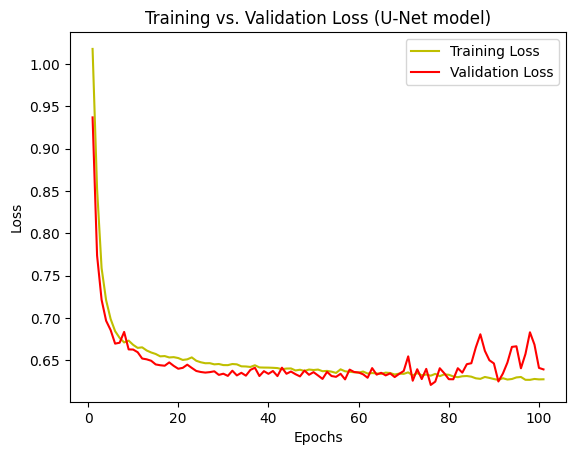

In [136]:
#Target is to reduce loss
loss = model1_history.history['loss']
val_loss = model1_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training vs. Validation Loss (U-Net model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('report_figures/tr_val_loss_m1.png')
plt.show()

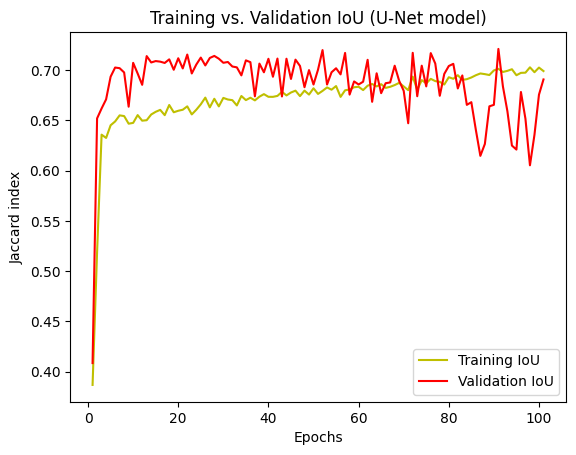

In [137]:
#Target is 1 (total overlap between truth and prediction)
jaccard_index = model1_history.history['jaccard_index']
val_jaccard_index = model1_history.history['val_jaccard_index']

epochs = range(1, len(jaccard_index) + 1)
plt.plot(epochs, jaccard_index, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_index, 'r', label="Validation IoU")
plt.title("Training vs. Validation IoU (U-Net model)")
plt.xlabel("Epochs")
plt.ylabel("Jaccard index")
plt.legend()
plt.savefig('report_figures/tr_val_iou_m1.png')
plt.show()

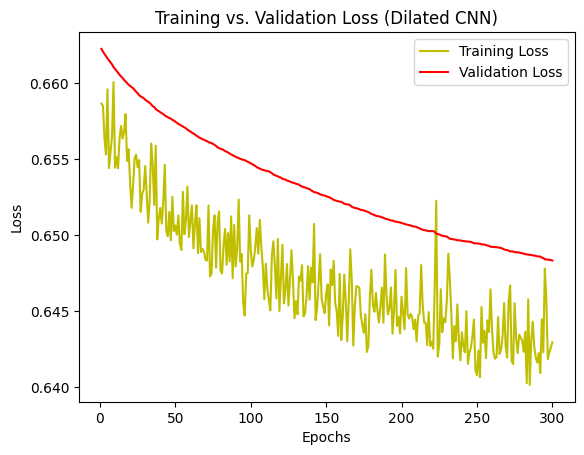

In [64]:
#Target is to reduce loss
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training vs. Validation Loss (Dilated CNN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('report_figures/tr_val_loss_m2_300epochs.png')
plt.show()

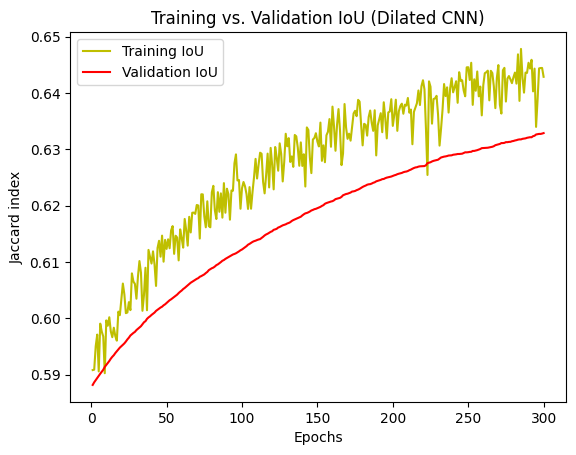

In [65]:
#Target is 1 (total overlap between truth and prediction)
jaccard_index = model2_history.history['jaccard_index']
val_jaccard_index = model2_history.history['val_jaccard_index']

epochs = range(1, len(jaccard_index) + 1)
plt.plot(epochs, jaccard_index, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_index, 'r', label="Validation IoU")
plt.title("Training vs. Validation IoU (Dilated CNN)")
plt.xlabel("Epochs")
plt.ylabel("Jaccard index")
plt.legend()
plt.savefig('report_figures/tr_val_iou_m2_300epochs.png')
plt.show()

### Model metrics for validation dataset

In [168]:
def eval_metrics(model, X, y):
    #True values for dataset
    y_argmax = np.argmax(y, axis=3)
    
    #Predictions
    y_pred = model.predict(X)
    #Note: In keras, the model is set to evaluation mode atomatically when "predict" is used
    
    #Get the position of the highest probability label (predicitons)
    y_pred_argmax = np.argmax(y_pred, axis=3)
    #axis = 3 to point to number of classes [(batch_size, height, width, num_classes)]
    
    loss, accuracy, jaccard  = model.evaluate(X, y)
    print(f"Test (Focal) Loss: {loss:.2f}")
    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Test Jaccard Index (IoU): {jaccard:.2f}")
    
    #All confusion matrix metrics
    class_names = ['No_forest', 'Forest']

    # Flatten the arrays
    y_true_flatten = y_argmax.flatten()
    y_pred_flatten = y_pred_argmax.flatten()

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true_flatten, y_pred_flatten)
    # Get proportions
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize=(5, 3))
    ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', 
                     xticklabels=class_names, yticklabels=class_names,annot_kws={"size": 8})

    # Set font sizes for the various plot elements
    plt.xlabel('Predicted Label', fontsize=8)
    plt.ylabel('True Label', fontsize=8)
    plt.title('Normalized Confusion Matrix', fontsize=10)

    # Reduce font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=7)
    colorbar = ax.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=8)

    plt.show()
    
    # Generate a classification report
    class_report = classification_report(y_true_flatten, y_pred_flatten)
    print(class_report)
    #Precision = TP / (TP + FP)
    #Recall = TP / (TP + FN)
    #F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
    #Support total occurencies of each class in the dataset
    
    return loss, accuracy, jaccard

In [169]:
def label_viz(model, X, y):
    random.seed(12)
    y_argmax = np.argmax(y, axis=3)
    y_pred = model.predict(X)

    # Initialize a figure with a grid of subplots
    plt.figure(figsize=(14, 12))

    # Loop over 4 random patches
    for i in range(4):
        # Select a random image index
        image_number = random.randint(0, len(X) - 1)

        # True values
        image = X[image_number]
        ground_truth_image = y_argmax[image_number]

        # Predicted values
        prediction = y_pred[image_number]
        predicted_image = np.argmax(prediction, axis=-1)

        # Plotting Original Image
        plt.subplot(4, 3, i * 3 + 1)
        plt.title("Original Image")
        plt.imshow(image)
        plt.axis('off')

        # Plotting Ground Truth (Masked Image)
        plt.subplot(4, 3, i * 3 + 2)
        plt.title("Original Masked Image")
        plt.imshow(ground_truth_image)
        plt.axis('off')

        # Plotting Predicted Image
        plt.subplot(4, 3, i * 3 + 3)
        plt.title("Predicted Image")
        plt.imshow(predicted_image)
        plt.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

##### Evaluation

2/2 [==============================] - 1s 433ms/step - loss: 0.6189 - accuracy: 0.8778 - jaccard_index: 0.7184
Test (Focal) Loss: 0.62
Test Accuracy: 0.88
Test Jaccard Index (IoU): 0.72


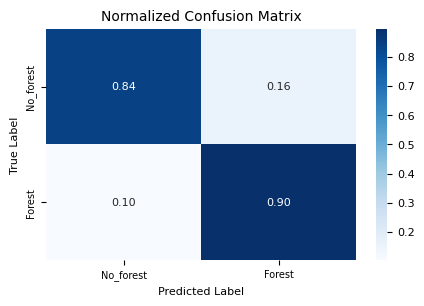

              precision    recall  f1-score   support

           0       0.81      0.84      0.83   1090886
           1       0.92      0.90      0.91   2054842

    accuracy                           0.88   3145728
   macro avg       0.86      0.87      0.87   3145728
weighted avg       0.88      0.88      0.88   3145728



(0.6189246773719788, 0.8777523040771484, 0.7184306383132935)

In [140]:
eval_metrics(model1, X_val, y_val)

2/2 [==============================] - 6s 2s/step - loss: 0.8144 - accuracy: 0.8210 - jaccard_index: 0.6334
Test (Focal) Loss: 0.81
Test Accuracy: 0.82
Test Jaccard Index (IoU): 0.63


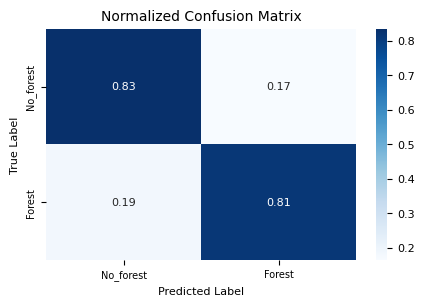

              precision    recall  f1-score   support

           0       0.70      0.83      0.76   1090886
           1       0.90      0.81      0.86   2054842

    accuracy                           0.82   3145728
   macro avg       0.80      0.82      0.81   3145728
weighted avg       0.83      0.82      0.82   3145728



(0.8143922686576843, 0.8209740519523621, 0.6333783268928528)

In [150]:
eval_metrics(model2, X_val, y_val)

##### Example labelling visualizations

2/2 [==============================] - 1s 353ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


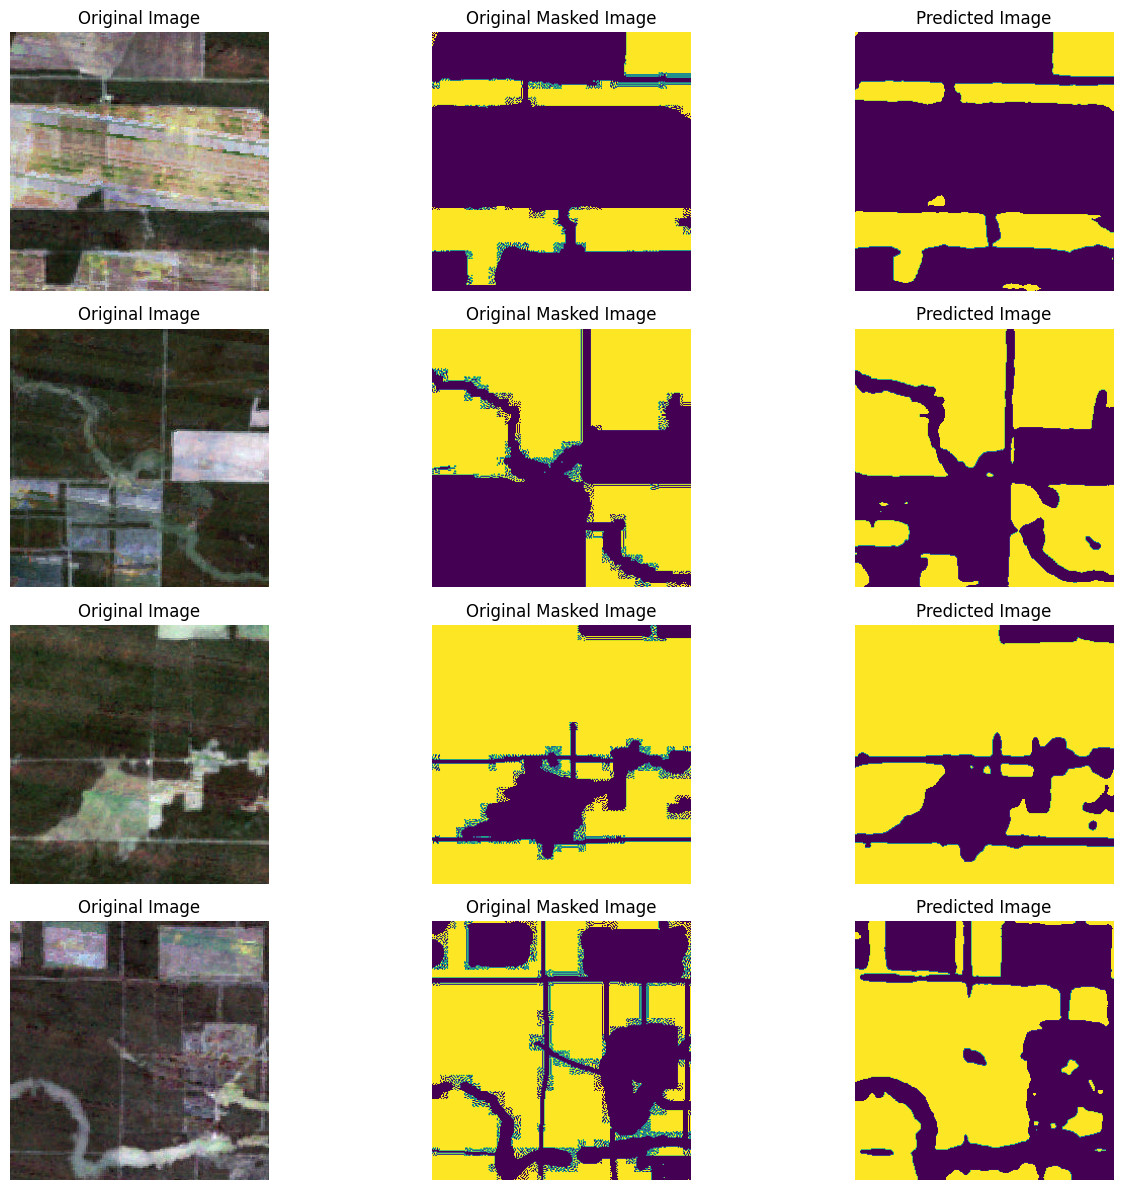

In [141]:
label_viz(model1, X_val, y_val)

2/2 [==============================] - 6s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


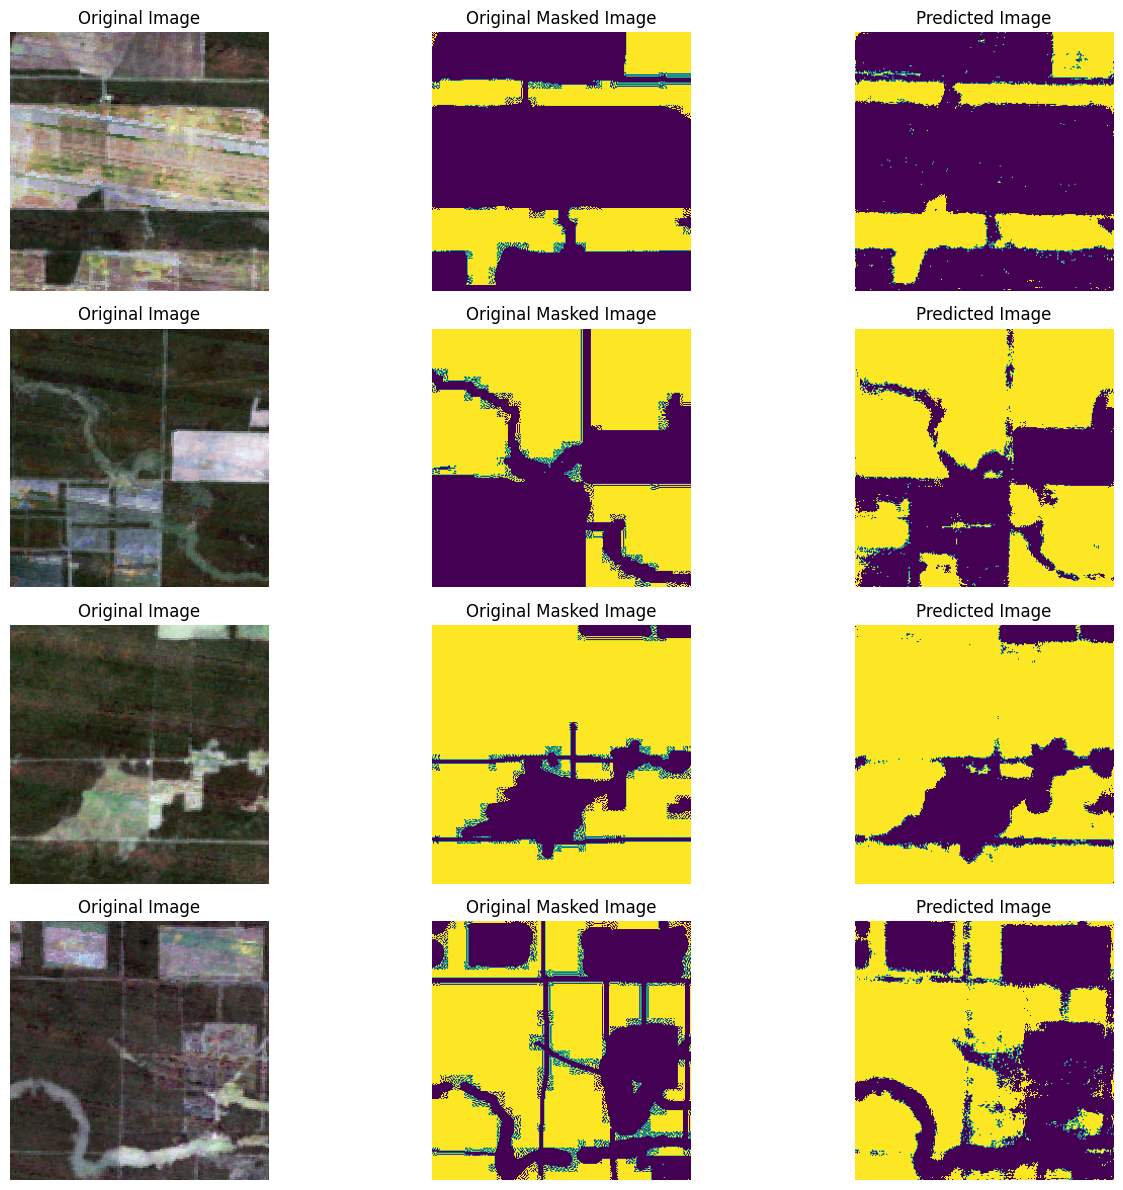

In [151]:
label_viz(model2, X_val, y_val)

In [ ]:
##Code for predicting just one image
#val_image = X_val[val_image_number]
#val_image_input = np.expand_dims(val_image, 0) #Add channel dimension for CNN
#prediction = model1.predict(val_image_input)
#predicted_image = np.argmax(prediction, axis=3)
#predicted_image = predicted_image[0,:,:]

### Model metrics for test dataset

Note: run "Installations and imports",  "Images preprocessing" and "Model metrics for validation dataset" functions and code below to perform prediction

In [ ]:
def jaccard_index(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    
    # intersection/whole area
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    
    return final_coef_value

In [ ]:
weights = [0.50, 0.50] 
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
#!ls -lah

#### Import and transform test dataset

In [160]:
#Patches for images
test_image_dataset, test_mask_dataset = image_patches(test_set)

#Label out of mask and categorial one-hot encodings
test_labels = label_dataset(test_mask_dataset)
test_labels_cat = to_categorical(test_labels, num_classes=2)

/satellite_chaco/Clipped_Scaled_Composite_2014_4.jpg
/satellite_chaco/Clipped_Scaled_Composite_2019_4.jpg
/masks_chaco/Clipped_Scaled_Composite_2014_4.jpg
/masks_chaco/Clipped_Scaled_Composite_2019_4.jpg


In [161]:
X_test, y_test = test_image_dataset, test_labels_cat

In [162]:
#Get the position of the highest probability label (true value)
y_test_argmax = np.argmax(y_test, axis=3)

#### Import model

In [163]:
#plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)
saved_model1 = load_model('models/forest_chaco_saved_model1_working.h5', custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                                                       'jaccard_index':jaccard_index})
# Print the model summary to verify it's loaded correctly
#saved_model1.summary()

In [164]:
#plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)
saved_model2 = load_model('models/forest_chaco_saved_model2.h5', custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                                                       'jaccard_index':jaccard_index})
# Print the model summary to verify it's loaded correctly
#saved_model1.summary()

#### Predict and assess predictions for test data

##### Prediction

In [165]:
y_test_pred = saved_model1.predict(X_test)
#Note: in keras, the model is set to evaluation mode atomatically when "predict" is used

2/2 [==============================] - 1s 97ms/step


In [166]:
#Get the position of the highest probability label (predicitons)
y_pred_test_argmax = np.argmax(y_test_pred, axis=3)
#axis = 3 to point to number of classes [(batch_size, height, width, num_classes)]

##### Evaluation

In [ ]:
#help(saved_model1.evaluate)

2/2 [==============================] - 1s 404ms/step - loss: 0.6024 - accuracy: 0.8905 - jaccard_index: 0.7400
Test (Focal) Loss: 0.60
Test Accuracy: 0.89
Test Jaccard Index (IoU): 0.74


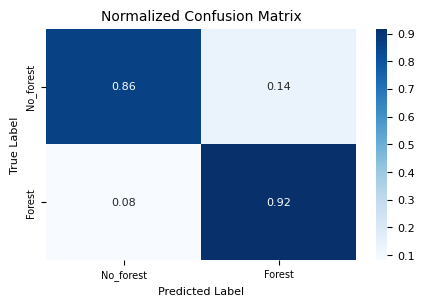

              precision    recall  f1-score   support

           0       0.91      0.86      0.88   1536784
           1       0.87      0.92      0.90   1608944

    accuracy                           0.89   3145728
   macro avg       0.89      0.89      0.89   3145728
weighted avg       0.89      0.89      0.89   3145728



(0.6024372577667236, 0.8904768824577332, 0.7400349974632263)

In [171]:
eval_metrics(model1, X_test, y_test)

2/2 [==============================] - 4s 1s/step - loss: 0.7815 - accuracy: 0.8646 - jaccard_index: 0.7046
Test (Focal) Loss: 0.78
Test Accuracy: 0.86
Test Jaccard Index (IoU): 0.70


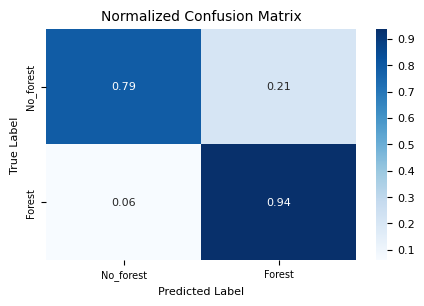

              precision    recall  f1-score   support

           0       0.92      0.79      0.85   1536784
           1       0.82      0.94      0.88   1608944

    accuracy                           0.86   3145728
   macro avg       0.87      0.86      0.86   3145728
weighted avg       0.87      0.86      0.86   3145728



(0.7815442681312561, 0.8645906448364258, 0.7046185731887817)

In [173]:
eval_metrics(model2, X_test, y_test)

##### Example labelling visualizations

2/2 [==============================] - 1s 458ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


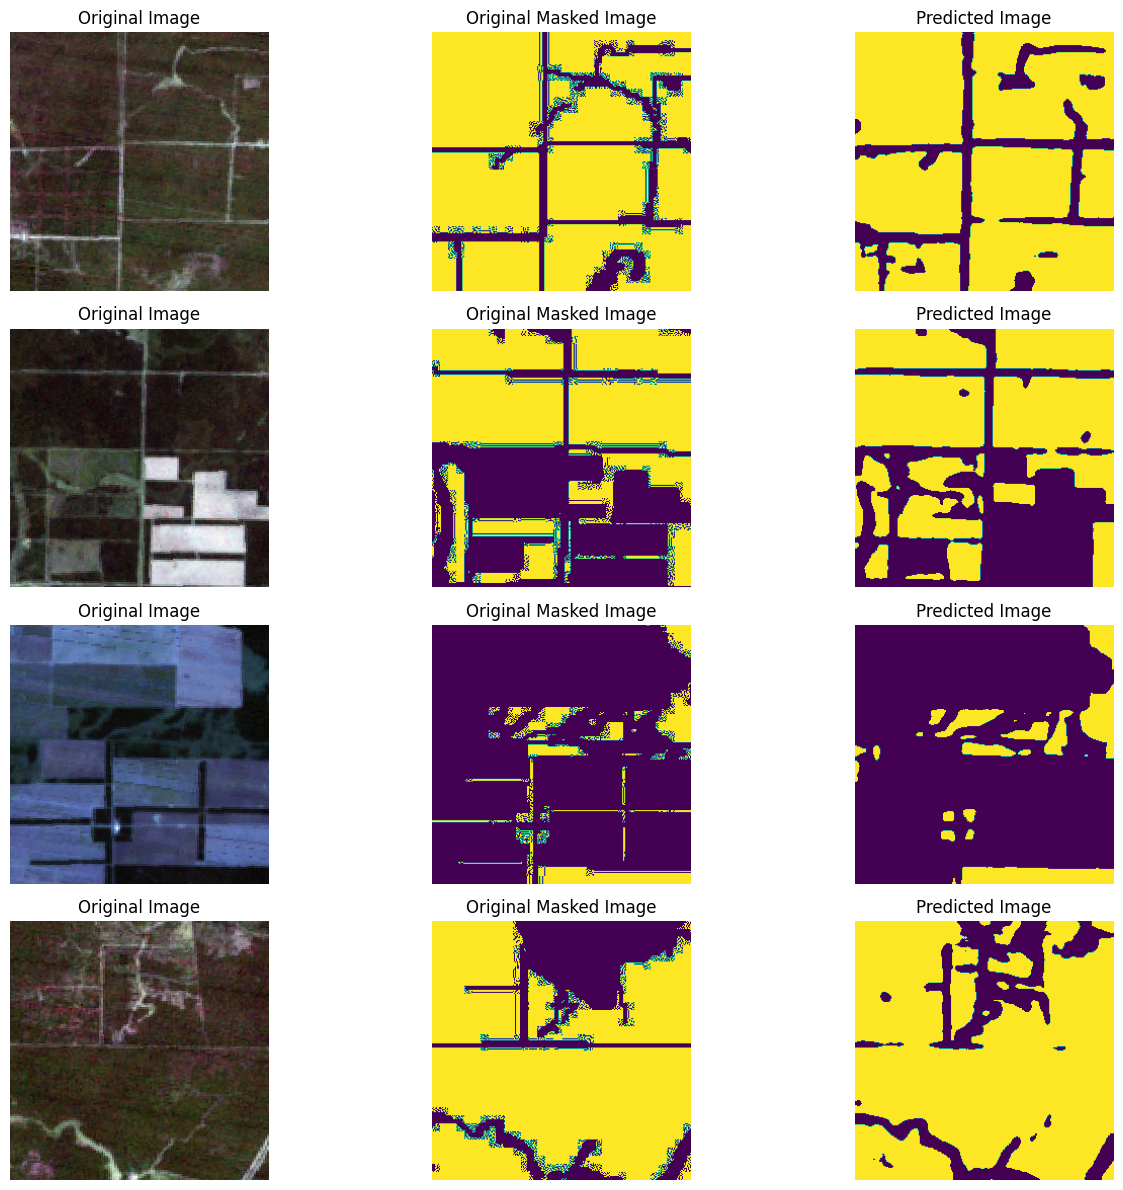

In [174]:
label_viz(saved_model1, X_test, y_test)

2/2 [==============================] - 7s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


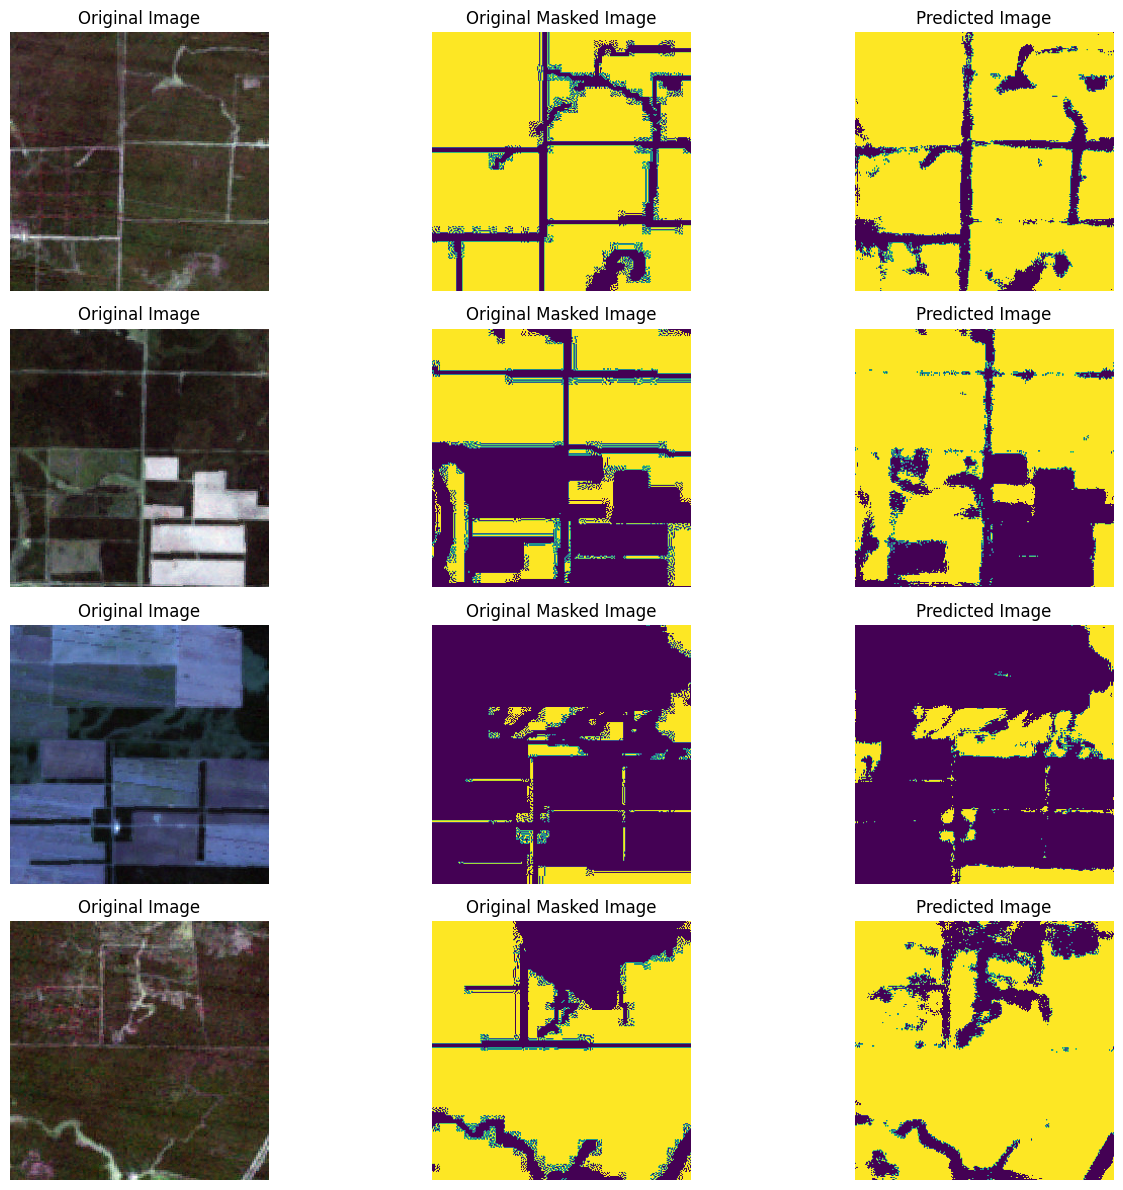

In [175]:
label_viz(saved_model2, X_test, y_test)